# Zero-noise extrapolation


ZNE is an error mitigation method that extrapolates the noiseless value from the multiple noise level values. The method consists of three steps:

(1) Whole or part of original circuit is extended to scale the noise level. This yields multiple circuits with various noise levels. The simplest case is noise level 3.0, where we generate the scaled circuit
$$
U_{\text{original}} \rightarrow U_{\text{original}}U^{-1}_{\text{original}}U_{\text{original}}.
$$
We can expect that this corresponds to noise level 3.0 since this circuit has three times as many gates as original gate has.

(2) Calculate the expectation value $\langle O(l)\rangle$ corresponding to each noise level, where $l$ is noise level and $\langle O(l)\rangle$ is the expectation value of operator $O$ at noise level $l$. That is, $l=1$ is the original circuit and $l > 1.0$ corresponds to the extended circuit.

(3) What we want to know is the expectation value $\langle O(0)\rangle$, which is the expectation value when there is no noise. We estimate it by extrapolation using multiple expectation values computed at different noise levels.



## Prerequisite

QURI Parts modules used in this tutorial: `quri-parts-algo`, `quri-parts-circuit`, `quri-parts-core` and `quri-parts-qulacs`. You can install them as follows:

In [ ]:
# !pip install "quri-parts[qulacs]"

## Preparation and overview

Here, we prepare the circuit and the noise model we use throughout this tutorial. The circuit we use in this tutorial consists of an identity part and a non-trivial part. The non-trivial part is responsible for converting the state $|000\rangle$ into  $\frac{1}{\sqrt{2}}\left(|000\rangle + |111\rangle\right)$, while we decompose the identity circuit into multiple gates to amplify the effect of the noises.

In [ ]:
from quri_parts.circuit import QuantumCircuit, draw_circuit # >= 0.22.0

qubit_count = 3

identity_circuit = QuantumCircuit(3)
identity_circuit.add_RX_gate(0, 1.3)
identity_circuit.add_RY_gate(1, 0.2)
identity_circuit.add_RZ_gate(0, -2.3)
identity_circuit.add_SqrtXdag_gate(1)
identity_circuit.add_T_gate(0)
identity_circuit.add_RX_gate(1, 0.4)
identity_circuit.add_RY_gate(0, 2.7)
identity_circuit.add_Tdag_gate(1)
identity_circuit.add_RY_gate(0, -2.7)
identity_circuit.add_T_gate(1)
identity_circuit.add_Tdag_gate(0)
identity_circuit.add_RX_gate(1, -0.4)
identity_circuit.add_RZ_gate(0, 2.3)
identity_circuit.add_SqrtX_gate(1)
identity_circuit.add_RX_gate(0, -1.3)
identity_circuit.add_RY_gate(1, -0.2)

circuit = QuantumCircuit(3)
circuit += identity_circuit
circuit.add_H_gate(0)
circuit.add_CNOT_gate(0, 1)
circuit.add_CNOT_gate(0, 2)


print("The circuit:")
draw_circuit(circuit, line_length=200)

The circuit:
   ___     ___     ___     ___     ___     ___     ___     ___     ___                  
  |RX |   |RZ |   | T |   |RY |   |RY |   |Tdg|   |RZ |   |RX |   | H |                 
--|0  |---|2  |---|4  |---|6  |---|8  |---|10 |---|12 |---|14 |---|16 |-----●-------●---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|     |       |   
   ___     ___     ___     ___     ___     ___     ___     ___             _|_      |   
  |RY |   |sXd|   |RX |   |Tdg|   | T |   |RX |   |sqX|   |RY |           |CX |     |   
--|1  |---|3  |---|5  |---|7  |---|9  |---|11 |---|13 |---|15 |-----------|17 |-----|---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|           |___|     |   
                                                                                   _|_  
                                                                                  |CX | 
----------------------------------------------------------------------------------|18 |-
        

Then, we create a noise model with some `NoiseInstruction`s. Here we consider `BitFlipNoise` and `DepolarizingNoise`.

In [ ]:
from quri_parts.circuit.noise import (
    BitFlipNoise,
    DepolarizingNoise,
    NoiseModel,
)

noise_model = NoiseModel([
    BitFlipNoise(error_prob=0.01),
    DepolarizingNoise(error_prob=0.01),
])

### Zero-noise extrapolation and peformance

Here, we explicitly show how to build an estimator that performs ZNE. In this simple example, we will compare the performance of a ZNE estimator  with that of noiseless and noisy esimators. We first prepare an operator for this purpose.

In [ ]:
from quri_parts.core.operator import Operator, pauli_label, PAULI_IDENTITY
op = Operator({
    pauli_label("Z0"): 0.25,
    pauli_label("Z1 Z2"): 2.0,
    pauli_label("X1 X2"): 0.5,
    pauli_label("Z1 Y2"): 1.0,
    pauli_label("X1 Y2"): 2.0,
    PAULI_IDENTITY: 3.0,
})

Next, we build a ZNE estimator. In this example, the ZNE estimator we create performs a quadratic regression using 3 data points, which corresponds to using 3 different scale factors. The gates that are folded are chosen randomly. Note that to create a ZNE estimator, we first need a noisy concurrent estimator, where we use the Qulacs density matrix concurrent estimator.

In [ ]:
from quri_parts.algo.mitigation.zne import create_polynomial_extrapolate, create_zne_estimator, create_folding_random
from quri_parts.qulacs.estimator import create_qulacs_density_matrix_concurrent_estimator

folding = create_folding_random()
scale_factors = [1.0, 2.0, 3.0]
poly_extrapolation = create_polynomial_extrapolate(order=2)
noisy_concurrent_estimator = create_qulacs_density_matrix_concurrent_estimator(noise_model)

zne_estimator = create_zne_estimator(
    noisy_concurrent_estimator, scale_factors, poly_extrapolation, folding
)

With the ZNE estimator at hand, let's compare it's performance against the noiseless and noisy estimators.

In [ ]:
from quri_parts.qulacs.estimator import create_qulacs_density_matrix_estimator, create_qulacs_vector_estimator
from quri_parts.core import quantum_state # `from quri_parts.core.state` in quri-parts < 0.22.0

state = quantum_state(qubit_count, circuit=circuit)
noiseless_estimator = create_qulacs_vector_estimator()
noisy_estimator = create_qulacs_density_matrix_estimator(noise_model)

print("Noiseless estimate:", noiseless_estimator(op, state).value.real)
print("Noisy estimate:", noisy_estimator(op, state).value.real)
print("ZNE estimate:", zne_estimator(op, state).value)

Noiseless estimate: 4.999999999999998
Noisy estimate: 4.409201598385634
ZNE estimate: 4.633232349742282


## Building the ZNE estimator step by step

Now we start to explain all the steps necessary to construct a ZNE estimator. This involves:

- Build a set of folded circuits by assigning a sequence of scaled factors.
- A noisy concurrent estimator is required to perform noisy estimation on the folded circuits. Then we obtain a set of data:
$$
\begin{equation}
    \left\lbrace (\text{ScaleFactor}_0, \text{NoisyEstimation}_0), \cdots \right\rbrace
\end{equation}
$$
- Pick a extrapolation scheme to predict the noiseless result ($\text{ScaleFactor} = 0$) from noisy estimations of the noisy estimator.

### Create scaled circuits

Next, create scaled circuits. To scale the circuits `scaling_circuit_folding` can be used. QURI Parts has multiple options for circuit folding. Here we use random folding. 

In [ ]:
from quri_parts.algo.mitigation.zne import (
    create_folding_random,
    scaling_circuit_folding,
)

random_folding = create_folding_random()
scale_factors = [1.0, 2.0, 3.0]
scaled_circuits: list[QuantumCircuit] = []

for scale_factor in scale_factors:
    print("")
    print(f"{scale_factor = }")
    scaled_circuits.append(
        scaled_circuit:=scaling_circuit_folding(circuit, scale_factor, random_folding)
    )
    draw_circuit(scaled_circuit, line_length=800)


scale_factor = 1.0
   ___     ___     ___     ___     ___     ___     ___     ___     ___                  
  |RX |   |RZ |   | T |   |RY |   |RY |   |Tdg|   |RZ |   |RX |   | H |                 
--|0  |---|2  |---|4  |---|6  |---|8  |---|10 |---|12 |---|14 |---|16 |-----●-------●---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|     |       |   
   ___     ___     ___     ___     ___     ___     ___     ___             _|_      |   
  |RY |   |sXd|   |RX |   |Tdg|   | T |   |RX |   |sqX|   |RY |           |CX |     |   
--|1  |---|3  |---|5  |---|7  |---|9  |---|11 |---|13 |---|15 |-----------|17 |-----|---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|           |___|     |   
                                                                                   _|_  
                                                                                  |CX | 
----------------------------------------------------------------------------------|18 |-
 

### Noisy estimation on folded circuits

In [ ]:
estimates = noisy_concurrent_estimator(
    [op], [quantum_state(qubit_count, circuit=scaled_circuit) for scaled_circuit in scaled_circuits]
)

for scale_factor, scaled_circuit, estimate in zip(scale_factors, scaled_circuits, estimates):
    print(
        f"scale factor {scale_factor}: {len(scaled_circuit.gates)=}, estimate: {estimate.value}"
    )

scale factor 1.0: len(scaled_circuit.gates)=19, estimate: (4.409201598385635+0j)
scale factor 2.0: len(scaled_circuit.gates)=37, estimate: (4.099074907751645+0j)
scale factor 3.0: len(scaled_circuit.gates)=57, estimate: (3.702852277840312+0j)


### Extrapolate zero-noise value

The last step is extrapolation. QURI Parts has multiple options for extrapolation. Here we use second-order polynomial extrapolation.

In [ ]:
from quri_parts.algo.mitigation.zne import create_polynomial_extrapolate

poly_extrapolation = create_polynomial_extrapolate(order=2)
exp_vals = poly_extrapolation(scale_factors, [e.value for e in estimates])
print(f"mitigated estimate: {exp_vals}")

mitigated estimate: (4.633232349742281+0j)


/home/ywatanabekoba/.cache/pypoetry/virtualenvs/quri-sdk-notebooks-dFiwJr5S-py3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ywatanabekoba/.cache/pypoetry/virtualenvs/quri-sdk-notebooks-dFiwJr5S-py3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


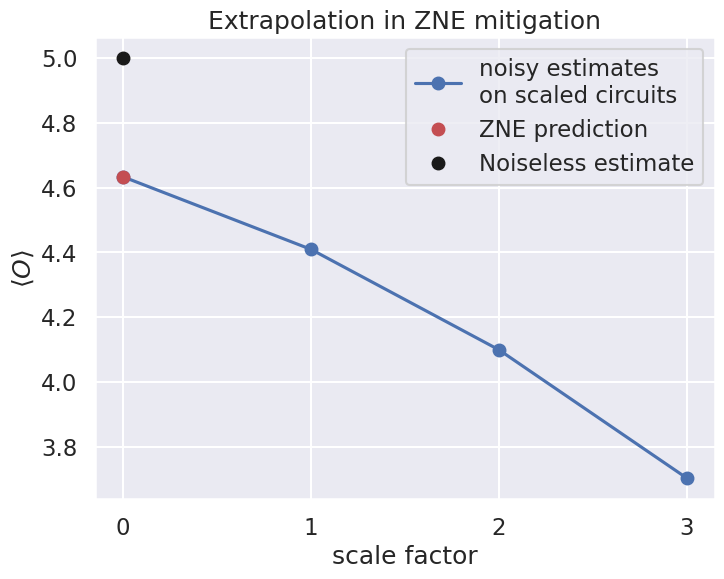

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("talk")
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot([0, *scale_factors], [exp_vals, *[e.value.real for e in estimates]], "-o", label="noisy estimates\non scaled circuits")
plt.plot([0], [exp_vals.real], "or", label="ZNE prediction")
plt.plot([0], [noiseless_estimator(op, state).value.real], "ok", label="Noiseless estimate")
plt.xlabel("scale factor")
plt.ylabel("$\\langle O \\rangle$")
plt.xticks([0, 1, 2, 3], [0, 1, 2, 3])
plt.title("Extrapolation in ZNE mitigation")
plt.legend()
plt.show()

### Create ZNE estimator

You can also create a `QuantumEstimator` that returns the error-mitigated estimate of a given operator and state by performing ZNE behind the scenes.

In [ ]:
from quri_parts.algo.mitigation.zne import create_zne_estimator

zne_estimator = create_zne_estimator(
    noisy_concurrent_estimator, scale_factors, poly_extrapolation, random_folding
)

mitigated_estimate = zne_estimator(op, state)
mitigated_estimate.value

4.63323234974228